In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use('default')
from pyfermions import *

# Compute energy density & relative error for various values of $(K,L)$

In [2]:
mera1d.selesnick(K=3, L=3).energy(10)

-0.63658762925589141

At level $M$, the contribution to the energy density is at most of order $2 \times2^{-(M+2)} = 2^{-M-1}$.
I.e. the error incurred by truncation is at most $2^{-M}$.

In [3]:
%%time
RECOMPUTE = False
FILENAME = 'mera1d_energies.csv'

if RECOMPUTE:
    # this is a rather pessimistic estimate, though, as we will see below
    ABS_ERROR_MAX = 1e-6
    M = int(-np.log2(ABS_ERROR_MAX) + 1)
    print('M =', M)

    data = {'K': [], 'L': [], 'M': [], 'E': []}
    for K in range(1, 5 + 1):
        for L in range(1, 10 + 1):
            if K + L > 10:
                continue
            print('K = %s, L = %s' % (K, L))

            E = mera1d.selesnick(K=K, L=L).energy(M)
            data['M'].append(M)
            data['K'].append(K)
            data['L'].append(L)
            data['E'].append(E)

    energies = pd.DataFrame(data)

    print('Saving to %s...' % FILENAME)
    energies.to_csv(FILENAME)
else:
    print('Loading %s...' % FILENAME)
    energies = pd.read_csv(FILENAME)
    M = energies['M'].unique()
    assert len(M) == 1, 'Expecting a single precision only at this point.'
    M = M[0]
    print('Done (M = %s)' % M)

Loading mera1d_energies.csv...
Done (M = 20)
CPU times: user 2.71 ms, sys: 1.8 ms, total: 4.5 ms
Wall time: 9.07 ms


Collect bond dimension and relative errors:

In [4]:
energies['chi'] = 2**(energies['K'] + energies['L'])

E_expected = -2 / np.pi
energies['rel_error'] = (E_expected - energies['E']) / E_expected

energies

,Unnamed: 0,E,K,L,M,chi,rel_error
0,0,-0.628022,1,1,20,4,1.350463e-02
1,1,-0.635271,1,2,20,8,2.118263e-03
2,2,-0.636336,1,3,20,16,4.463159e-04
3,3,-0.636551,1,4,20,32,1.087963e-04
4,4,-0.636601,1,5,20,64,2.929281e-05
5,5,-0.636614,1,6,20,128,8.500938e-06
6,6,-0.636618,1,7,20,256,2.615449e-06
7,7,-0.636619,1,8,20,512,8.429070e-07
8,8,-0.636620,1,9,20,1024,2.820479e-07
9,9,-0.631519,2,1,20,8,8.011952e-03


# Plot for our paper (as in https://arxiv.org/pdf/1109.5334.pdf Fig. 17/Table II)

In [5]:
# bond dimension vs. minimal relative error
min_errors = energies.groupby('chi').rel_error.agg(
    ['min']).rename(columns={
        'min': 'min_rel_error'
    }).reset_index()
min_errors

,chi,min_rel_error
0,4,1.350463e-02
1,8,2.118263e-03
2,16,4.463159e-04
3,32,1.087963e-04
4,64,2.114880e-05
5,128,4.457904e-06
6,256,1.041020e-06
7,512,2.392295e-07
8,1024,5.113369e-08


In [6]:
# exponential fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    np.log2(min_errors['chi']), np.log2(min_errors['min_rel_error']))

slope, intercept

(-2.2246092590608848, -2.0726917384643357)

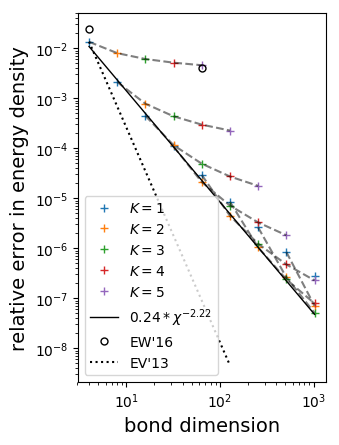

In [7]:
plt.figure(figsize=(3.2, 4.8))

# our results
for K, data in energies.groupby(['K']):
    p = plt.loglog(data['chi'], data['rel_error'], '+', label='$K = %d$' % K)

for L, data in energies.groupby(['L']):
    plt.loglog(
        data['chi'],
        data['rel_error'],
        '--',
        color='black',
        alpha=.5,
        label='_nolegend_')
#     chi, rel_error = data.iloc[len(data) // 2][['chi', 'rel_error']]
#     plt.annotate(
#         '$L = %d$' % L,
#         xy=(chi, rel_error),
#         xycoords='data',
#         color='black',
#         alpha=.5)

# exponential fit
chi = energies['chi'].unique()
plt.loglog(
    chi,
    2**intercept * chi**slope,
    '-b',
    color='black',
    linewidth=1,
    label='$%.02f * \chi^{-%.2f}$' % (2**intercept, -slope))

# Evenbly-White (2016) - this is for the Ising model, so should square the bond dimension
chi_EW = np.array([2, 8])
error_EW = np.array([0.024, 0.004])
plt.loglog(
    chi_EW**2,
    error_EW,
    '.k',
    label="EW'16",
    markersize=10,
    markerfacecolor='none')

# Evenbly-Vidal (2013), XX model
chi_EV = chi[chi < 200]
plt.loglog(chi_EV, 5.25 * chi_EV**(-4.30), ':k', label="EV'13")

plt.legend()
plt.xlabel('bond dimension', fontsize=14)
plt.ylabel('relative error in energy density', fontsize=14)
# plt.show()

plt.savefig('energies1d.pdf', bbox_inches='tight')

# Two-Point Function

K = 1, L = 1
K = 3, L = 3


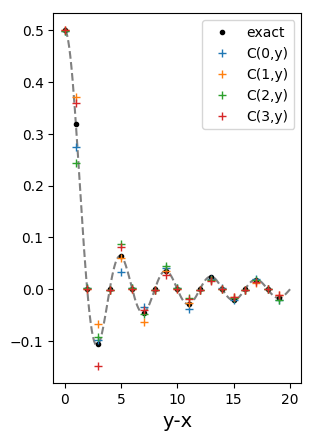

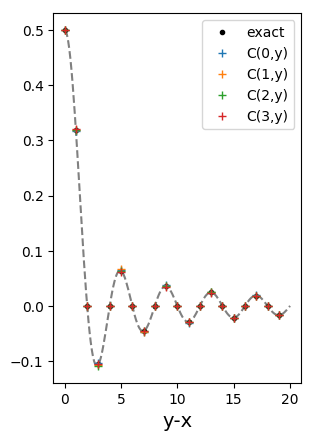

In [8]:
for (K, L) in [(1, 1), (3, 3)]:
    print('K = %d, L = %d' % (K, L))
    plt.figure(figsize=(3.2, 4.8))

    # exact (scatter and line)
    delta_x = np.linspace(1e-10, 20, 200)
    exact = np.sin(np.pi / 2 * delta_x) / (np.pi * delta_x)
    plt.plot(delta_x, exact, '--', color='.5')

    delta_x = np.arange(1e-10, 20)
    exact = np.sin(np.pi / 2 * delta_x) / (np.pi * delta_x)
    plt.plot(delta_x, exact, '.', color='k', label='exact')

    # MERA
    delta_x = np.arange(0, 20)
    x = np.arange(0, 4)
    m = mera1d.selesnick(K, L)
    C = m.correlation(delta_x, levels=10, x=x)
    for i, x in enumerate(x):
        plt.plot(delta_x, C[i, :], '+', label='C(%s,y)' % x)

    plt.xlabel("y-x", fontsize=14)
    plt.legend()
    plt.savefig('twopoint1d-%d-%d.pdf' % (K, L), bbox_inches='tight')